# Clustering using Python tools
Tested with QuPath 0.6.0rc3 on Win11<br>
This section builds off of the following resources: https://www.youtube.com/watch?v=984Jz2QCvng<br>
Instructions: https://github.com/qupath/i2k-qupath-for-python-programmers<br>
Documentation?: https://qupath.github.io/qubalab-docs/<br>
Thanks to the work of Alan O'Callaghan

Create an environment and install qubalab into it with<br>
<kbd>conda create -n yourEnvironmentName python=3.10</kbd><br>
<kbd>pip install --upgrade qubalab </kbd><br>
<kbd>pip install ipython leidenalg igraph umap-learn</kbd><br>
<kbd>pip install seaborn[stats]</kbd>


## Start QuPath, open your project and an image, and open a connection
The .gif shows both opening a connection, and seeing that the Python symbol is red, and closing the connection.<br>
Do not close the connection unless you are done!<br>
<img src= "Images/ps_startconnection.gif" width = "800"><br>


In [7]:
from qubalab.qupath import qupath_gateway
from qubalab.images.qupath_server import QuPathServer
import matplotlib.pyplot as plt

#This uses the default gateway 25333, make sure to change this to match the one you created in QuPath if you altered this.
gateway = qupath_gateway.create_gateway(auth_token=None, port=25333)
gateway
qupath_server = QuPathServer(gateway) # read pixels from qupath via gateway

I used the following script to create cells, feel free to follow along if you have access to the sample data.



In [ ]:
setImageType('FLUORESCENCE');
createFullImageAnnotation(true)
qupath.ext.instanseg.core.InstanSeg.builder()
    .modelPath("F:/Scripts/fluorescence_nuclei_and_cells")
    .device("cpu")
    .inputChannels([ColorTransforms.createChannelExtractor("Hoechst"), ColorTransforms.createChannelExtractor("CD31"), ColorTransforms.createChannelExtractor("CD11c"), ColorTransforms.createChannelExtractor("CD68"), ColorTransforms.createChannelExtractor("CD163"), ColorTransforms.createChannelExtractor("CD20"), ColorTransforms.createChannelExtractor("CD4"), ColorTransforms.createChannelExtractor("CD8a"), ColorTransforms.createChannelExtractor("CD45RO"), ColorTransforms.createChannelExtractor("PDL1"), ColorTransforms.createChannelExtractor("LAG3"), ColorTransforms.createChannelExtractor("PD1"), ColorTransforms.createChannelExtractor("CD45"), ColorTransforms.createChannelExtractor("S100a")])
    .outputChannels()
    .tileDims(512)
    .interTilePadding(32)
    .nThreads(12)
    .makeMeasurements(true)
    .randomColors(false)
    .build()
    .detectObjects()
clearSelectedObjects(true);

## Data cleaning in QuPath
Possibly run some filtering on the cells, to remove outliers or objects we do not think fit our analysis. These scripts are for use in QuPath, not Python.

In [ ]:
//QuPath script, do not run here

toRemove = []
//Cycle through all of the detected objects, and check for any that do not have a nucleus
//There are a variety of ways of doing this, but one is checking for NaNs in measurements for nuclei.
for (cell in getDetectionObjects()){
    if (cell.measurements.get("Nucleus: Solidity").isNaN()){
        toRemove.add(cell)
    }else if (cell.measurements.get("Nucleus: Area µm^2") ==cell.measurements.get("Cell: Area µm^2")){
        //Additionally, remove any cells that have the exact same area of nucleus and cytoplasm.
        //This is mostly a demonstration of another way to remove certain kinds of detected outliers.
        toRemove.add(cell)
    }
}
print "Objects removed: " + toRemove.size()
removeObjects(toRemove, true)

Additionally, the UMAP function run below throws an error if ANY value is NaN. Since we are cycling through all of the "mean" values, let's go ahead and remove all cells with a mean NaN value.

In [ ]:
//QuPath script do not run here

toRemove = []

// Iterate over all objects
for (def pathObject in getAllObjects()) {
    // Check if any measurement contains "Mean" and has a NaN value
    if (pathObject.measurements.any { key, value -> key.contains("Mean") && Double.isNaN(value) }) {
        toRemove.add(pathObject)
    }
}

// Remove the collected objects
removeObjects(toRemove, true)

## Back in Python, let's use the connection
Check the state of QuPath by taking a snapshot of the interface - not necessary, but something that is neat to know how to do.

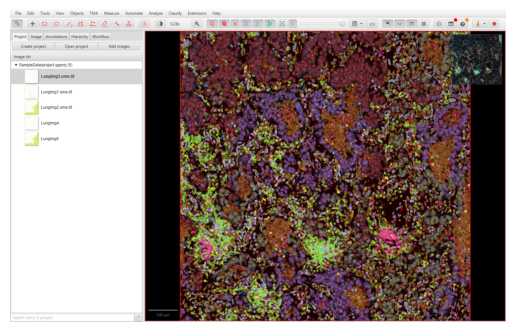

In [20]:
plt.imshow(qupath_gateway.create_snapshot())
plt.axis(False)
plt.show()

## Create a dataframe using cell measurements
Generate a basic dataframe using pandas, and normalize it - something important to keep in mind when performing clustering as different channels in a multiplex image can have vastly different values, yet represent the same amount of protein or have similar impacts on classification.<br>
There are many methods of normalization, this is a fairly simple one.<br>
https://pmc.ncbi.nlm.nih.gov/articles/PMC4779207/<br>
https://www.nature.com/articles/s41598-018-22489-1<br>
Depending on the setting, variation in the samples (genetically identical mice vs genetically diverse humans, variation in human sample collection and fixation protocols) and other complications, different methods of normalization may be called for. Check with your local statistician and be ready to explain where sources of variation!

### Note that the below method makes the very simple assumption that ALL images in the project are part of the project.
Consider: Are the measurements in all channels relevant? Didn't we basically turn off some channels right at the start?<br>
Further cleaning of your data can both improve results and reduce processing time!
### Beyond this point, make sure to check whether you are running the "Single image" or "Full project" code - they do not mix!

In [9]:
#Full project

import pandas as pd
project = gateway.getProject()
detections = []
detection_to_image = {}

for imageEntry in project.getImageList():
    imageData = imageEntry.readImageData()
    hierarchy = imageData.readHierarchy()
    imageDetections = hierarchy.getDetectionObjects()
    #Extra processing here to make sure we can map detections back to the correct image
    for det in imageDetections:
        uuid = det.getID().toString()
        detections.append(det)
        detection_to_image[uuid] = imageEntry.getID()  # Store mapping of detection to image number

print(len(detections))
names = detections[0].getMeasurementList().getNames()
names = [x for x in names if x.endswith("Mean")]

df = pd.DataFrame(columns=["UUID", "ImageID"] + names)
for det in detections:
    df = df._append(
        {
            "UUID": det.getID().toString(),
            "ImageID": detection_to_image[det.getID().toString()],
            **{name: det.getMeasurements().get(name) for name in names}
        },
        ignore_index=True
    )

# Standardize numeric columns (excluding UUID and ImageID)
numeric_df = df.drop(columns=["UUID", "ImageID"])  
normalized_df = (numeric_df - numeric_df.mean()) / numeric_df.std()

print(df.head())
print(normalized_df.head())


30332


C:\Users\MichaelSNelson\AppData\Local\Temp\ipykernel_24856\3829759939.py:23: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = df._append(


                                   UUID ImageID  Nucleus: Hoechst: Mean  \
0  850cc52f-0b5f-42e7-b618-4ca23a31b1fd       4             3023.105225   
1  00c63d85-6940-4906-9061-7f9d770d37a5       4             1521.521362   
2  873abe89-909e-4517-88ae-179c3fdd4fa3       4             1793.666626   
3  035b4ddf-7db6-4147-899a-c7802a4e8bb5       4             4332.055664   
4  b7b8177e-028d-4c04-905b-a35a43447696       4              643.525635   

   Nucleus: AF1: Mean  Nucleus: CD31: Mean  Nucleus: CD11c: Mean  \
0         1844.157837           514.789490            425.684204   
1         1658.265015           458.239319            380.786316   
2         1310.111084           414.666656            411.555542   
3         1833.888916           480.888885            334.722229   
4         5577.538574           815.474365            442.051270   

   Nucleus: CD68: Mean  Nucleus: CD163: Mean  Nucleus: CD20: Mean  \
0           327.473694            398.078949           313.552643   
1 

In [8]:
# Single image

import pandas as pd
detections = []
detections = gateway.getDetectionObjects()
names = detections[0].getMeasurementList().getNames()
names = [x for x in names if x.endswith("Mean")]

df = pd.DataFrame(columns = names)
for det in detections:
    df = df._append(
        {name: det.getMeasurements().get(name) for name in names},
        ignore_index=True)


# standardise the columns to avoid scale and shift effects
normalized_df = (df - df.mean()) / df.std()

C:\Users\MichaelSNelson\AppData\Local\Temp\ipykernel_804\3830618156.py:8: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = df._append(


## Running UMAP
https://umap-learn.readthedocs.io/en/latest/<br>
We could now run a dimensionality reduction algorithm, which might help us to visualise classifiers or other analyses in QuPath.<br>

We can also add these features back into QuPath.

In [15]:
# Single image
import umap

# run a dimensionality reduction algorithm on the measurements
embedding = umap.UMAP().fit_transform(normalized_df)

# assign back to measurement list
for i in range(embedding.shape[0]):
    detections[i].getMeasurementList().put("UMAP1", float(embedding[i][0]))
    detections[i].getMeasurementList().put("UMAP2", float(embedding[i][1]))

F:\miniconda\envs\qubalab\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
F:\miniconda\envs\qubalab\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


In [17]:
# Full project
import umap

# Run UMAP dimensionality reduction
embedding = umap.UMAP().fit_transform(normalized_df)

# Create a dictionary mapping UUID to UMAP values
umap_results = {df.iloc[i]["UUID"]: (float(embedding[i, 0]), float(embedding[i, 1])) for i in range(len(df))}

for imageEntry in project.getImageList():
    imageData = imageEntry.readImageData()
    hierarchy = imageData.getHierarchy()
    imageDetections = hierarchy.getDetectionObjects()
    for det in imageDetections:
        uuid = det.getID().toString()
        image_id = imageEntry.getID()

        # Ensure we're updating only detections that belong to the current image
        if uuid in umap_results and detection_to_image[uuid] == image_id:
            det.getMeasurementList().put("UMAP1", umap_results[uuid][0])
            det.getMeasurementList().put("UMAP2", umap_results[uuid][1])
    imageEntry.saveImageData(imageData)


F:\miniconda\envs\qubalab\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Plot the UMAP using Python

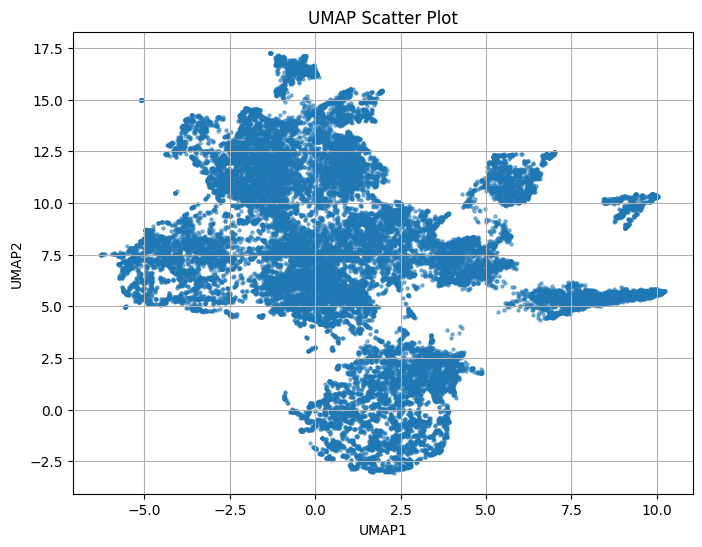

In [23]:
# Extract UMAP1 and UMAP2 values from the embedding
umap1 = embedding[:, 0]
umap2 = embedding[:, 1]

# Create a scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(umap1, umap2, s=5, alpha=0.5)  # s=5 sets small point size, alpha=0.5 for transparency
plt.xlabel("UMAP1")
plt.ylabel("UMAP2")
plt.title("UMAP Scatter Plot")
plt.grid(True)

# Show the plot
plt.show()

Plot the UMAP using QuPath!<br>
Run the following script in the QuPath script editor to plot the UMAP for the objects in the current image

In [ ]:
//QuPath script, do not run here
import qupath.lib.gui.charts.Charts

nameOfActiveImage = getProjectEntry().getImageName()

def builder = Charts.scatterChart()
    .viewer(QuPathGUI.getInstance().getViewer())
    .title('UMAP for '+ nameOfActiveImage)
    .measurements(getDetectionObjects(), "UMAP1", "UMAP2")
    .show()

Plot the UMAP for all detections in the project

In [ ]:
//QuPath script, do not run here
import qupath.lib.gui.charts.Charts

project = QP.getProject()
detections = []
for (imageEntry: project.getImageList()) {
    hierarchy = imageEntry.readHierarchy()
    detections += hierarchy.getDetectionObjects()
}

def builder = Charts.scatterChart()
    .viewer(QuPathGUI.getInstance().getViewer())
    .title('UMAP based on mean channel intensities')
    .measurements(detections, "UMAP1", "UMAP2")
    .show()

## Preparing to cluster cells
We can identify the KNN graph of the cells, and turn this into an adjacency matrix.

In [19]:
from sklearn.neighbors import kneighbors_graph
import igraph

# find KNN graph
A = kneighbors_graph(normalized_df, 50)

# convert matrix to adjacency graph
g = igraph.Graph.Adjacency((A > 0))

### kneighbors_graph What’s happening?
We are building a network (graph) where each cell (data point) is connected to its 50 nearest neighbors based on their feature similarity.<br><br>
Why 50?<br>
This number controls how connected the graph is. A small value (e.g., 5-10) might not connect all data points well, while a large value (e.g., 100+) could make clusters too mixed.<br>
50 is a commonly used middle-ground: it provides enough connections to detect meaningful groups while keeping clusters distinct.<br><br>
How does "nearest neighbors" work?<br>
It measures similarity between cells based on their feature values (e.g., intensity measurements) and links each cell to its 50 most similar neighbors.

### igraph.Graph.Adjacency What’s happening?
The KNN graph (A) is stored as a matrix where each row represents a cell and each column represents whether it's connected to another cell.<br>
The (A > 0) part checks whether there is a connection (1 for connected, 0 for not connected).<br>
This converts the matrix into a proper graph structure using igraph, so that we can apply clustering.<br><br>
Why use > 0?<br>
This ensures that we only keep meaningful connections (i.e., cells that are actually linked in the KNN graph).<br>
The matrix A stores distances between points, but all we care about is whether a connection exists.<br>

## Running clustering
Then, we can cluster the adjacency. We could also have done K-means or something similar.<br>
https://leidenalg.readthedocs.io/en/stable/reference.html

In [17]:
#For single image
import leidenalg

# partition the KNN graph based on graph modularity
partition = leidenalg.find_partition(g, leidenalg.ModularityVertexPartition)

# assign the partitions as classes to the original QuPath objects
for i in range(embedding.shape[0]):
    detections[i].setClassification(f"Cluster {partition.membership[i]}")

In [21]:
#For project

import leidenalg

# partition the KNN graph based on graph modularity
partition = leidenalg.find_partition(g, leidenalg.ModularityVertexPartition)

# Create dictionary mapping UUIDs to cluster labels
cluster_results = {
    df.iloc[i]["UUID"]: f"Cluster {partition.membership[i]}" 
    for i in range(len(df))
}

# assign the partitions as classes to the original QuPath objects
for imageEntry in project.getImageList():
    imageData = imageEntry.readImageData()
    hierarchy = imageData.getHierarchy()
    imageDetections = hierarchy.getDetectionObjects()

    for det in imageDetections:
        uuid = det.getID().toString()
        image_id = imageEntry.getID()

        # Ensure we're updating only detections that belong to the current image
        if uuid in cluster_results and detection_to_image[uuid] == image_id:
            det.setClassification(cluster_results[uuid])
    imageEntry.saveImageData(imageData)

### find_partition What’s happening?

This groups the cells into clusters using the Leiden algorithm, which is designed to find highly connected groups in a graph.<br>
The method used here is ModularityVertexPartition, which finds groups that maximize a measure called modularity.<br><br>
What is "Modularity"?<br>

Modularity measures how well-defined clusters are.<br>
A high modularity score means nodes in the same cluster are highly connected to each other, but weakly connected to nodes in other clusters.
The algorithm keeps adjusting cluster assignments to maximize modularity, ensuring meaningful groups.<br><br>
Why use ModularityVertexPartition?<br>

This is a standard way of defining clusters in a network.<br>
It ensures that groups are found based on connections, not just distance.<br>
This method is commonly used in biological and medical data where we are dealing with complex, non-linear relationships between features.

In [ ]:
Collect information about clusters

## What is wrong with clustering from one image?
## How is classification different?
## Create classifiers from clustering results?

In [19]:
Get average information per measurement about each cluster!! Or die.
Generate heatmaps!!!11eleven

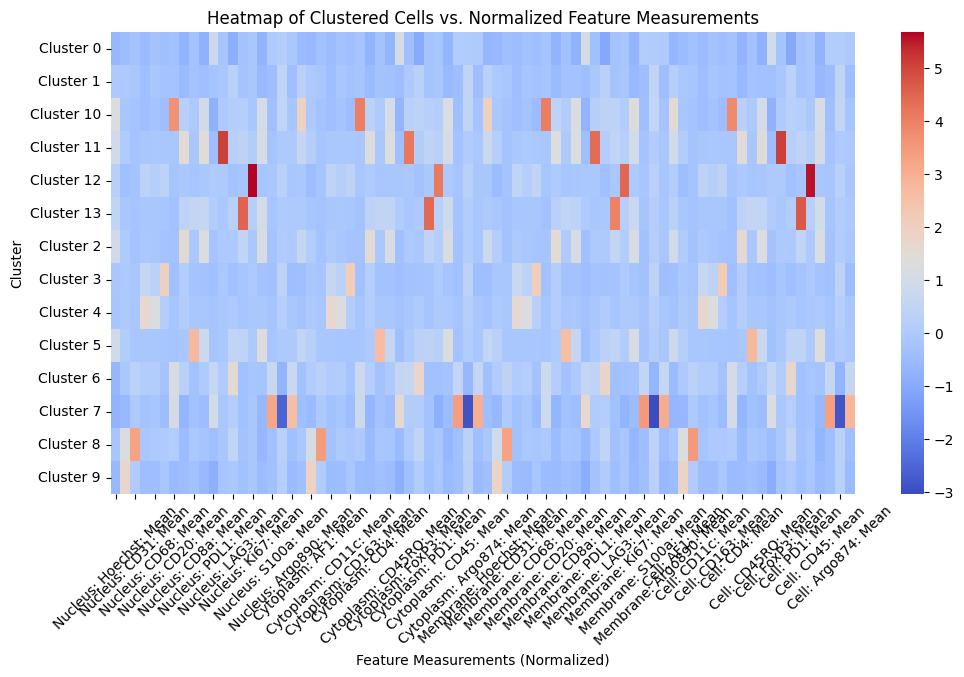

In [26]:
import seaborn as sns
import matplotlib.pyplot as plt

# Add cluster labels to the normalized DataFrame
normalized_df["Cluster"] = df["UUID"].map(cluster_results)  # Assign clusters to data

# Group by cluster and compute the mean of each **normalized** feature
cluster_means = normalized_df.groupby("Cluster").mean(numeric_only=True)

# Plot heatmap with normalized values
plt.figure(figsize=(12, 6))
sns.heatmap(cluster_means, cmap="coolwarm", annot=False)  # Set annot=True to show values
plt.title("Heatmap of Clustered Cells vs. Normalized Feature Measurements")
plt.xlabel("Feature Measurements (Normalized)")
plt.ylabel("Cluster")
plt.xticks(rotation=45)
plt.show()


## What a mess!
Let's filter this, and rename some of the features so they do not clutter up our reading of the heatmap.

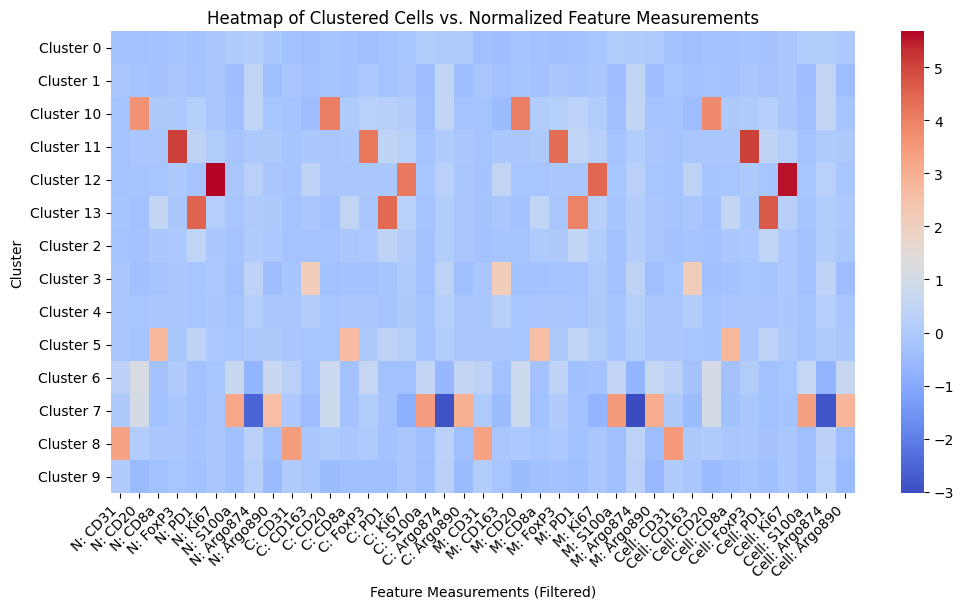

In [32]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set threshold for filtering features
threshold = 2  # Ignore features with all values between -2 and 2

# Add cluster labels to the normalized DataFrame
normalized_df["Cluster"] = df["UUID"].map(cluster_results)  # Assign clusters to data

# Group by cluster and compute the mean of each normalized feature
cluster_means = normalized_df.groupby("Cluster").mean(numeric_only=True)

# Filter out features that do not exceed the threshold in any cluster
filtered_features = cluster_means.columns[
    (cluster_means.max(axis=0) > threshold) | (cluster_means.min(axis=0) < -threshold)
]
cluster_means_filtered = cluster_means[filtered_features]  # Keep only these features

# Function to clean feature names
def clean_feature_name(name):
    name = name.replace(": Mean", "")  # Remove ": Mean" suffix
    name = name.replace("Nucleus", "N").replace("Cytoplasm", "C").replace("Membrane", "M")  # Abbreviate
    return name

# Apply cleaning function to feature names
cleaned_feature_names = [clean_feature_name(name) for name in cluster_means_filtered.columns]

# Plot heatmap with filtered features
plt.figure(figsize=(12, 6))
ax = sns.heatmap(cluster_means_filtered, cmap="coolwarm", annot=False)  # Set annot=True to show values
ax.set_xticklabels(cleaned_feature_names, rotation=45, ha="right")  # Align right for better readability

plt.title("Heatmap of Clustered Cells vs. Normalized Feature Measurements")
plt.xlabel("Feature Measurements (Filtered)")
plt.ylabel("Cluster")
plt.xticks(rotation=45)
plt.show()


## Patterns!

The repeated patterns here suggest that we did not need all of the nuclear, cytoplasmic, and cell measurements, as the same channels show the same patterns for each cluster, per area of the cell!

What are the clusters without any extreme measurements? What happens with Cluster 9 if we set the threshold to 1.8?